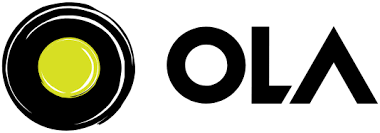
* 🎯 **Objective**: For Ola, a leading ride-sharing platform committed to delivering reliable, affordable, and convenient urban transportation, the challenge lies in optimizing driver retention to sustain operational efficiency and customer satisfaction. Despite its efforts, the company grapples with a persistent churn rate among its drivers, necessitating a proactive approach to ensure driver loyalty and minimize attrition.To address this challenge, Ola seeks to leverage its wealth of driver data to uncover underlying patterns in driver behavior, performance, and satisfaction. By harnessing the power of data science and ensemble learning techniques, Ola aims to develop predictive models capable of anticipating potential driver churn. These models will serve as a cornerstone of Ola's driver retention strategy, enabling the company to implement timely interventions and tailored incentives to mitigate churn risk effectively.

* 📊 **Project Breakdown**: This analytical journey encompasses the following methodologies and techniques:

* 🔍 **Exploratory Data Analysis (EDA)**: Comprehensive exploration to identify patterns, correlations, and outliers.
* 🛠 **Feature Engineering**: Innovating from the existing dataset to enhance model classification.
* 📐 **Random Forests, XGboost and GBDT** : Constructing a bagging and boosting models using Sklearn.
* 📝 **Classification Report**: Detailed metrics including accuracy, precision, recall, and F1-score.
* 📉 **ROC-AUC Curve Analysis**: Evaluating class distinction ability.

### Importing Libraries

In [1]:
# Scientific libraries
import numpy as np
import pandas as pd 
import scipy
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_validate,GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, auc, roc_curve
import xgboost as xgb 
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import GradientBoostingClassifier as gbc

# Visual libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Helper libraries (Not that important, can be skipped)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(index_col=0,
    filepath_or_buffer = 'https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv')
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


### Understanding the Dataset:

* MMMM-YY : Reporting Date (Monthly)
* Driver_ID : Unique id for drivers
* Age : Age of the driver
* Gender : Gender of the driver – Male : 0, Female: 1
* City : City Code of the driver
* Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
* Income : Monthly average Income of the driver
* Date Of Joining : Joining date for the driver
* LastWorkingDate : Last date of working for the driver
* Joining Designation : Designation of the driver at the time of joining
* Grade : Grade of the driver at the time of reporting
* Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
* Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

### Data exploration and wrangling

In [3]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [4]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 2.0+ MB


In [5]:
# MMM-YY is nothing but date, let's change the datatype to date and also rename the column
df.rename(columns={'MMM-YY':'date'},inplace=True)

In [6]:
df['date']=pd.to_datetime(df['date'])

As you can see,there is no target variable in the dataset, we have to check the lastworkingdate column and create our own target variable. If nan is given for the last entry of lastworking date column for a particular driver_id then that means he did not churn and if a value is non nan then that means that particular driver churned.

In [7]:
# Converting Dateofjoining and LastWorkingDate to datetime format
df['Dateofjoining']=pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])

### Null values handling

In [8]:
df.isna().sum()

date                        0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [9]:
df['Gender'].value_counts()

Gender
0.0    11074
1.0     7978
Name: count, dtype: int64

The dataset is not that big it has around 20k rows, so let's impute the age and gender using KNN Imputer

### KNN Imputation

In [10]:
from sklearn.impute import KNNImputer
knn = KNNImputer(n_neighbors=5,weights='distance',metric='nan_euclidean')

In [11]:
df.isna().sum()

date                        0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [12]:
# Imputing age column
df['Age']=knn.fit_transform(df[['Age']])

In [13]:
df.isna().sum()

date                        0
Driver_ID                   0
Age                         0
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [14]:
# Imputing Gender column
df['Gender']=knn.fit_transform(df[['Gender']])

### Feature creation

In [15]:
# Adding Quarter
df['quarter']=df['date'].dt.quarter

In [16]:
# Checking how many months are negative and zero total business value
df['negative_TBV']=(df['Total Business Value']<0).astype(int)
df['zero_TBV']=(df['Total Business Value']==0).astype(int)

In [17]:
# How well each driver earned i each quarter 
df.groupby(['Driver_ID','quarter'])[['Total Business Value']].sum().sort_index(ascending=[True,True])

Total Business Value
Driver_ID quarter                      
1         1                     1715580
2         4                           0
4         1                      350000
          2                           0
          4                           0
...                                 ...
2787      1                      977830
          2                           0
2788      2                           0
          3                     1686340
          4                      611900

[5963 rows x 1 columns]

The above dataframe gives us how much each driver earned in each quarter

In [18]:
df_grouped = df.groupby(['Driver_ID','date']).agg(
{
    'Age':'max',
    'Gender':'first',
    'City':'last',
    'Education_Level':'max',
    'Income':np.mean,
    'Dateofjoining':'last',
    'LastWorkingDate':'last',
    'Joining Designation':'last',
    'Grade':'last',
    'Total Business Value':'sum',
    'Quarterly Rating':np.mean,
    'negative_TBV':'last',
    'zero_TBV':'last'
})

In [19]:
df_grouped

Age  Gender City  Education_Level   Income  \
Driver_ID date                                                      
1         2019-01-01  28.0     0.0  C23                2  57387.0   
          2019-02-01  28.0     0.0  C23                2  57387.0   
          2019-03-01  28.0     0.0  C23                2  57387.0   
2         2020-11-01  31.0     0.0   C7                2  67016.0   
          2020-12-01  31.0     0.0   C7                2  67016.0   
...                    ...     ...  ...              ...      ...   
2788      2020-08-01  30.0     0.0  C27                2  70254.0   
          2020-09-01  30.0     0.0  C27                2  70254.0   
          2020-10-01  30.0     0.0  C27                2  70254.0   
          2020-11-01  30.0     0.0  C27                2  70254.0   
          2020-12-01  30.0     0.0  C27                2  70254.0   

                     Dateofjoining LastWorkingDate  Joining Designation  \
Driver_ID date                                                            
1         2019-01-01    2018-12-24             NaT                    1   
          2019-02-01    2018-12-24             NaT                    1   
          2019-03-01    2018-12-24      2019-03-11                    1   
2         2020-11-01    2020-11-06             NaT                    2   
          2020-12-01    2020-11-06             NaT                    2   
...                            ...             ...                  ...   
2788      2020-08-01    2020-06-08             NaT                    2   
          2020-09-01    2020-06-08             NaT                    2   
          2020-10-01    2020-06-08             NaT                    2   
          2020-11-01    2020-06-08             NaT                    2   
          2020-12-01    2020-06-08             NaT                    2   

                      Grade  Total Business Value  Quarterly Rating  \
Driver_ID date                                                        
1         2019-01-01      1               2381060               2.0   
          2019-02-01      1               -665480               2.0   
          2019-03-01      1                     0               2.0   
2         2020-11-01      2                     0               1.0   
          2020-12-01      2                     0               1.0   
...                     ...                   ...               ...   
2788      2020-08-01      2                740280               3.0   
          2020-09-01      2                448370               3.0   
          2020-10-01      2                     0               2.0   
          2020-11-01      2                200420               2.0   
          2020-12-01      2                411480               2.0   

                      negative_TBV  zero_TBV  
Driver_ID date                                
1         2019-01-01             0         0  
          2019-02-01             1         0  
          2019-03-01             0         1  
2         2020-11-01             0         1  
          2020-12-01             0         1  
...                            ...       ...  
2788      2020-08-01             0         0  
          2020-09-01             0         0  
          2020-10-01             0         1  
          2020-11-01             0         0  
          2020-12-01             0         0  

[19104 rows x 13 columns]

In [20]:
# I will sort the above grouped dataframe with driver id and date for our next dataframe
df_grouped = df_grouped.sort_index(ascending=[True,True],axis=0)

In [21]:
df_new = df_grouped.groupby('Driver_ID').agg(
{
    'Age':'max',
    'Gender':'first',
    'City':'last',
    'Education_Level':'max',
    'Income': 'last',
    'Dateofjoining':'last',
    'LastWorkingDate':'last',
    'Joining Designation':'last',
    'Grade':'last',
    'Total Business Value':'sum',
    'Quarterly Rating':np.mean,
    'negative_TBV':'sum',
    'zero_TBV':'sum'   
}
)

* Since we have multiple columns with each Driver_ID, we will group by driver id and use it for analysis
* I am taking city last because his last city will be more useful for predicting he is churning/ staying.
* For income we can take last.
* I am taking mean here for quarterly rating because it feels more suitable in this case.
* I am taking sum of zero_tbv and negative_tbv so that I will have columns with total number of months a driver had zero total business value or negative total business value which will be useful for our analysis.

In [22]:
df_new.reset_index(inplace=True)

In [23]:
df_new['Quarterly Rating']=round(df_new['Quarterly Rating'],0)

In [24]:
df_new

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,negative_TBV,zero_TBV
0,1,28.0,0.0,C23,2,57387.0,2018-12-24,2019-03-11,1,1,1715580,2.0,1,1
1,2,31.0,0.0,C7,2,67016.0,2020-11-06,NaT,2,2,0,1.0,0,2
2,4,43.0,0.0,C13,2,65603.0,2019-12-07,2020-04-27,2,2,350000,1.0,0,4
3,5,29.0,0.0,C9,0,46368.0,2019-01-09,2019-03-07,1,1,120360,1.0,0,2
4,6,31.0,1.0,C11,1,78728.0,2020-07-31,NaT,3,3,1265000,2.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,34.0,0.0,C24,0,82815.0,2015-10-15,NaT,2,3,21748820,3.0,0,2
2377,2785,34.0,1.0,C9,0,12105.0,2020-08-28,2020-10-28,1,1,0,1.0,0,3
2378,2786,45.0,0.0,C19,0,35370.0,2018-07-31,2019-09-22,2,2,2815090,2.0,0,3
2379,2787,28.0,1.0,C20,2,69498.0,2018-07-21,2019-06-20,1,1,977830,2.0,0,3


* If there is NAN in my lastworkingdate column that means the driver did not churn, if we find a date in lastworkingdate it means the driver chruned. 
* Let's convert the column lastworkingdate to Target, where churned is 1 and stayed is 0.

In [25]:
df_new['Target']=df_new['LastWorkingDate'].notnull().astype(int)

In [26]:
df_new['Target'].value_counts()

Target
1    1616
0     765
Name: count, dtype: int64

In [27]:
# Since now we have target column, we can drop the lastworkingdate column
df_new.drop(columns=['LastWorkingDate'],inplace=True)

In [28]:
# Let's add income increased column which has 1 if income has been increased for the driver between first and last months
income_f = df_grouped.groupby('Driver_ID').agg({'Income':'first'})
#Quarterly rating at the end
income_l = df_grouped.groupby('Driver_ID').agg({'Income':'last'})
df_new['income_increased']=np.where(income_l - income_f > 0, 1,0)

In [29]:
df_new['income_increased'].value_counts()

income_increased
0    2338
1      43
Name: count, dtype: int64

In [30]:
# Let's add one more column which has 1 if quarterly rating has been increased between the first and last months 

qrf = df_grouped.groupby('Driver_ID').agg({'Quarterly Rating':'first'})
qrl = df_grouped.groupby('Driver_ID').agg({'Quarterly Rating':'last'})

df_new['rating_increased']=np.where(qrl-qrf>0,1,0)

In [31]:
df_new['rating_increased'].value_counts()

rating_increased
0    2023
1     358
Name: count, dtype: int64

In [32]:
# Final Dataframe on which we are going to do our analysis
df_new.head(5)

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,Joining Designation,Grade,Total Business Value,Quarterly Rating,negative_TBV,zero_TBV,Target,income_increased,rating_increased
0,1,28.0,0.0,C23,2,57387.0,2018-12-24,1,1,1715580,2.0,1,1,1,0,0
1,2,31.0,0.0,C7,2,67016.0,2020-11-06,2,2,0,1.0,0,2,0,0,0
2,4,43.0,0.0,C13,2,65603.0,2019-12-07,2,2,350000,1.0,0,4,1,0,0
3,5,29.0,0.0,C9,0,46368.0,2019-01-09,1,1,120360,1.0,0,2,1,0,0
4,6,31.0,1.0,C11,1,78728.0,2020-07-31,3,3,1265000,2.0,0,4,0,0,1


### Graphical Analysis and Visualizations

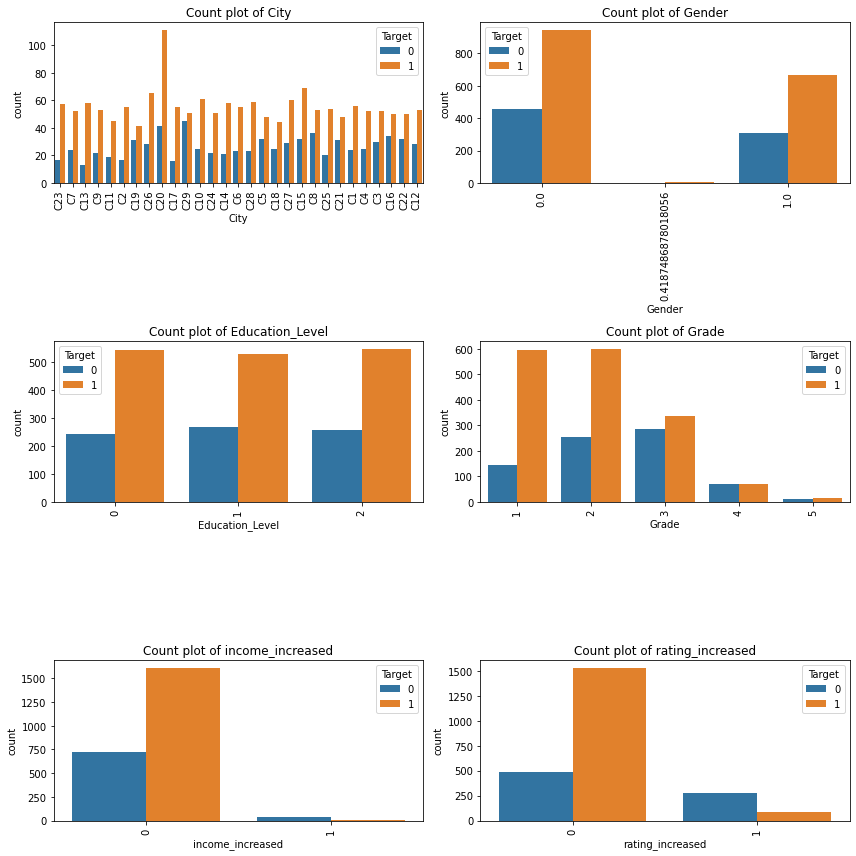

In [33]:
cols = ['City', 'Gender', 'Education_Level', 'Grade', 'income_increased', 'rating_increased']

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Plotting
for i in range(len(cols)):
    row = i // 2  # Calculate the row index
    col = i % 2   # Calculate the column index
    sns.countplot(x=cols[i], hue='Target', data=df_new, ax=axes[row, col])
    axes[row, col].set_xlabel(cols[i])
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=90)
    axes[row, col].set_title(f"Count plot of {cols[i]}")

plt.tight_layout()
plt.show()

Observations from the above count plots
* Highest churn rate is found in the city C20, this might be due to traffic or good public transport system of that particular city. Ola should incentivise the drivers of that city to decrease the churn rate.
* Most churn rate is found in males compared to females.
* There is no major impact of education on the churn rate.
* Highest churn rate is found in lower grade drivers.
* The churn rate is almost zero for drivers whose income increased.

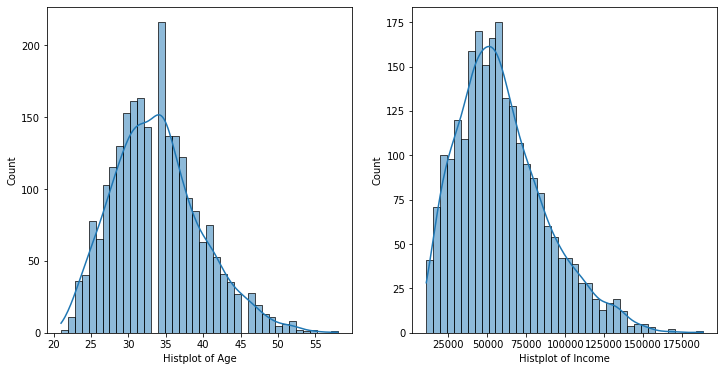

In [34]:
# Distribution of Age and Income 
fig,axes = plt.subplots(1,2,figsize=(12,6))
sns.histplot(data=df_new,x='Age',kde=True,ax=axes[0],bins=40)
axes[0].set_xlabel(f"Histplot of Age")
sns.histplot(data=df_new,x='Income',kde=True,ax=axes[1],bins=40)
axes[1].set_xlabel("Histplot of Income")
plt.show()

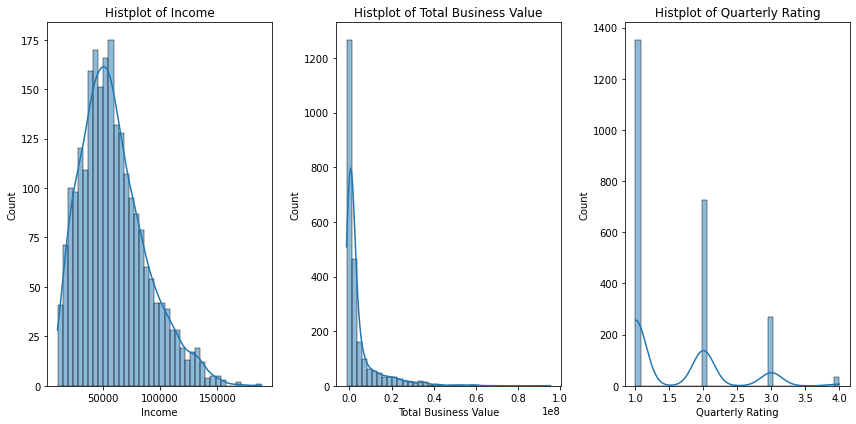

In [35]:
cols = ['Income','Total Business Value','Quarterly Rating']
fig,axes = plt.subplots(1,3,figsize=(12,6))
for i in range(len(cols)):
    sns.histplot(data=df_new,x=cols[i],palette='viridis',kde=True,bins=40,ax=axes[i])
    axes[i].set_xlabel(f"{cols[i]}")
    axes[i].set_title(f"Histplot of {cols[i]}")
plt.tight_layout()
plt.show()

* Total Business value, Income and Age are right skewed.
* ML algorithms do not work well with skewed data.
* Let's make 2 datasets, 1 with these skewed dataset and the other with some kind of transformation like log, square root or any such other transformations.

In [36]:
df_2 = df_new.copy()

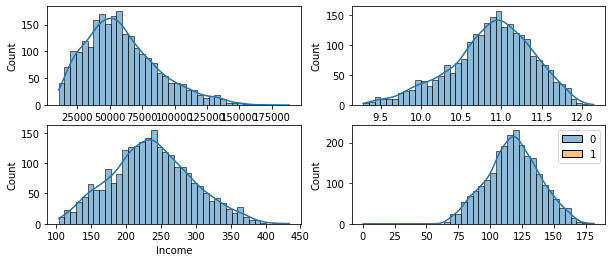

In [37]:
# Let's apply log, sqrt and boxcox transformations on income,age and total business value

plt.subplots(figsize=(10,4))
plt.subplot(221)
sns.histplot(data=df_2,x='Income',kde=True,bins=40)

plt.subplot(222)
sns.histplot(np.log(df_2['Income']),kde=True,bins=40)

plt.subplot(223)
sns.histplot(np.sqrt(df_2['Income']),kde=True,bins=40)

plt.subplot(224)
sns.histplot(scipy.stats.boxcox(df_2['Income']),kde=True,bins=40)
plt.show()

In [38]:
# Now let's plot qqplot for all these 
df_2['sqrt_income']=np.sqrt(df_2['Income'])

In [39]:
df_2['boxcox_income'],_ = scipy.stats.boxcox(df_2['Income'])

In [40]:
df_2['log_income'] = np.log(df_2['Income'])

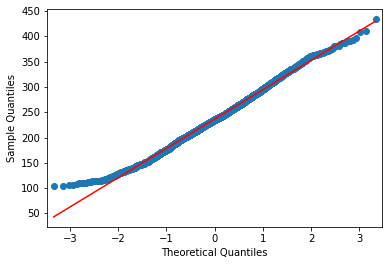

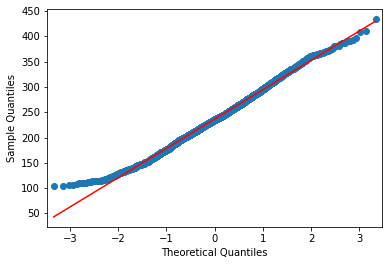

In [41]:
# QQplot of sqrt of income
sm.qqplot(df_2['sqrt_income'],line='s')

As we can see QQplot of Square root transformed income looks more normal

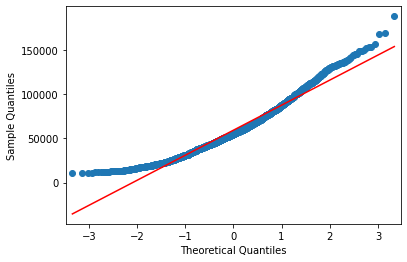

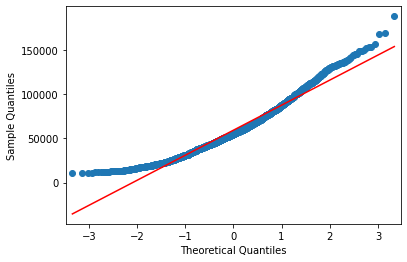

In [42]:
# QQplot of Income without transformation
sm.qqplot(df_2['Income'],line='s')

The qqplot of income without any transformation doesn't look like normal distribution.

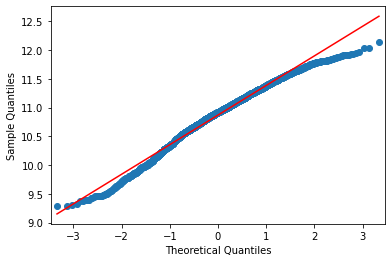

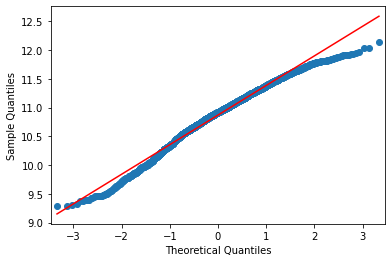

In [43]:
sm.qqplot(df_2['log_income'],line='s')

Log transformation is better but still not as good as square root transformation.

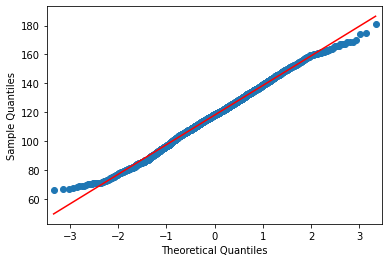

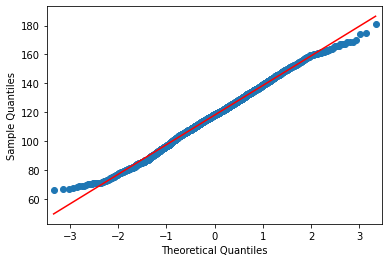

In [44]:
sm.qqplot(df_2['boxcox_income'],line='s')

Boxcox looks the best out of all the transformation so I will keep the boxcox income and remove all other transformations.

In [45]:
df_2.drop(columns=['Income','sqrt_income','log_income'],inplace=True)

In [46]:
# Now transforming total business value, we have negative values in total business value.
# we cannot apply boxcox if there are negative values
# We cannot apply log transformation also if there are negative values
# Let's apply yeo johnson transformation which can handle both positive and negative values

df_2['sqrt_TBV'] = round(np.sqrt(df_2['Total Business Value']),2)

In [47]:
df_2['yeo_TBV'],_ = scipy.stats.yeojohnson(df_2['Total Business Value'])

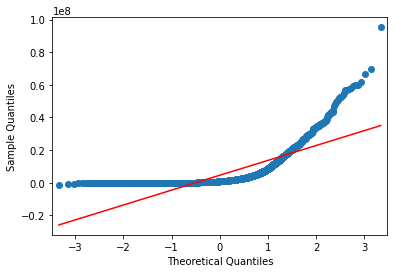

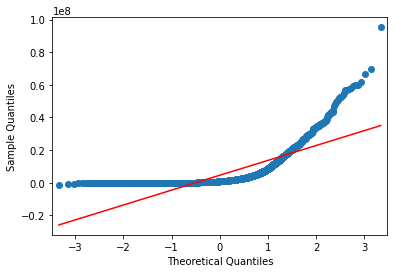

In [48]:
sm.qqplot(df_2['Total Business Value'],line='s')

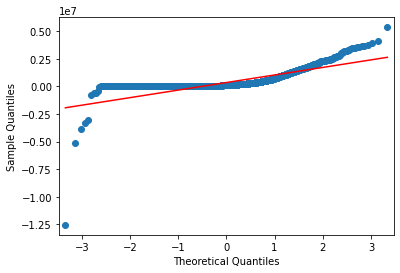

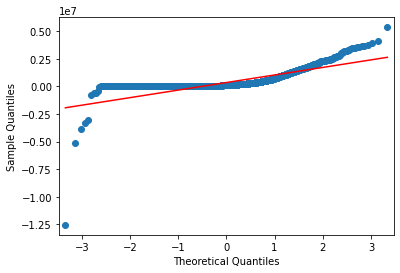

In [49]:
sm.qqplot(df_2['yeo_TBV'],line='s')

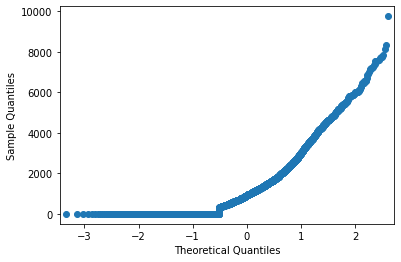

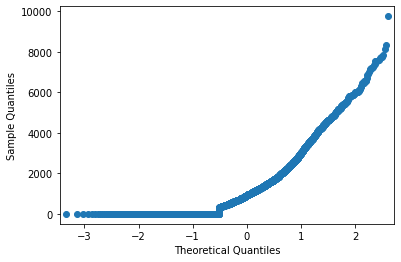

In [50]:
sm.qqplot(df_2['sqrt_TBV'],line='s')

As can be seen above none of the transformations is giving normal distribution.
But yeo_TBV is better compared to other transformations so removing other columns except yeo_TBV

In [51]:
df_2.drop(columns=['Total Business Value','sqrt_TBV'],inplace=True)

The purpose of creation of df_2 with transformed columns is to see whether we will have significant impact on the accuracy of model with non transformed columns and with transformed columns.

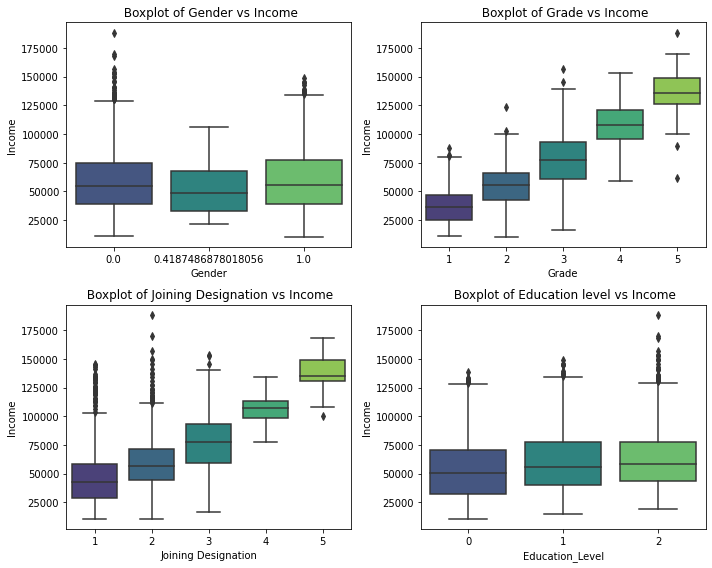

In [52]:
plt.subplots(figsize=(10,8))
plt.subplot(221)
sns.boxplot(data=df_new,x='Gender',y='Income',palette='viridis')
plt.title(f" Boxplot of Gender vs Income")

plt.subplot(222)
sns.boxplot(data=df_new,x='Grade',y='Income',palette='viridis')
plt.title(f" Boxplot of Grade vs Income")

plt.subplot(223)
sns.boxplot(data=df_new,x='Joining Designation',y='Income',palette='viridis')
plt.title(f" Boxplot of Joining Designation vs Income")

plt.subplot(224)
sns.boxplot(data=df_new,x='Education_Level',y='Income',palette='viridis')
plt.title(f" Boxplot of Education level vs Income")
plt.tight_layout()
plt.show()

According to the above plots
* As designation increases the income also increases.
* As Grade increases the income also increases.
* There is not a very significant difference of income for different education level (This should not me commented without doing hypothesis testing, but in the case I am writing the observations as per naked eye observation)

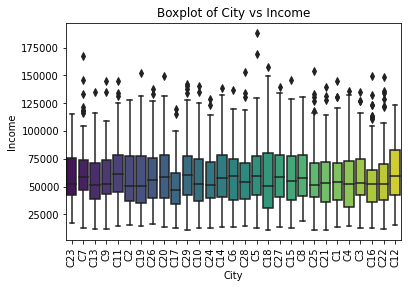

In [53]:
sns.boxplot(data=df_new,x='City',y='Income',palette='viridis')
plt.xticks(rotation=90)
plt.title(f"Boxplot of City vs Income")
plt.show()

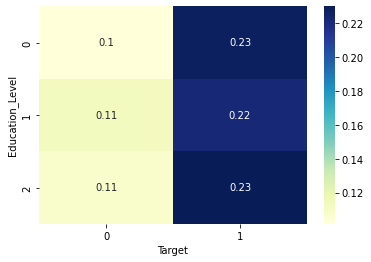

In [54]:
sns.heatmap(pd.crosstab(df_new['Education_Level'],df_new['Target'],normalize=True,margins=False),
           annot=True,cmap='YlGnBu')
plt.show()

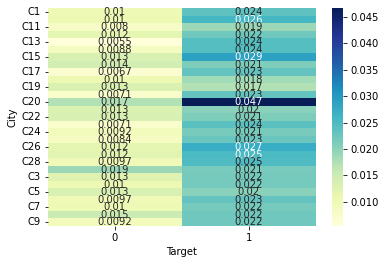

In [55]:
sns.heatmap(pd.crosstab(df_new['City'],df_new['Target'],normalize=True,margins=False),
           annot=True,cmap='YlGnBu')
plt.show()

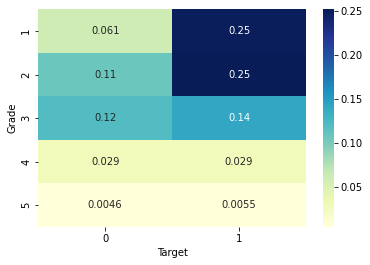

In [56]:
sns.heatmap(pd.crosstab(df_new['Grade'],df_new['Target'],normalize=True,margins=False),
           annot=True,cmap='YlGnBu')
plt.show()

### Data preprocessing

In [57]:
# We can remove driver id as it is just a unique identifier and will not add any impact on dependent variable
# Remving Date of joining also as it also doesn't have any impact on our churning rate.(From domain knowledge)

X = df_new.drop(columns=['Driver_ID','Target','Dateofjoining'])

In [58]:
y = df_new['Target']

In [59]:
X_2 = df_2.drop(columns=['Driver_ID','Dateofjoining','Target'])

In [60]:
y_2 = df_2['Target']

In [61]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [62]:
x_train_2,x_test_2,y_train_2,y_test_2 = train_test_split(X_2,y_2,test_size=0.2,random_state=0)

In [63]:
# We have to encode only City column rest all are already in numerical form
from category_encoders import TargetEncoder
target = TargetEncoder()

In [64]:
x_train['City']=target.fit_transform(x_train['City'],y_train)

In [65]:
x_test['City']=target.transform(x_test['City'])

In [66]:
target2 = TargetEncoder()
x_train_2['City']=target2.fit_transform(x_train_2['City'],y_train_2)

In [67]:
x_test_2['City']=target2.transform(x_test_2['City'])

Here let's try applying bagging and boosting algorithms, since these just work by splitting there is no need to scale the data.

### Modelling

In [68]:
# Just fitting a simple model to see the accuracy
model_1 = rfc(n_estimators=100,criterion='entropy',n_jobs=-1,random_state=0)

In [69]:
model_1.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)

In [70]:
model_1.score(x_test,y_test)

0.7777777777777778

In [71]:
model_1.score(x_train,y_train)

1.0

This is completely overfitting.

* With just a default model we got an accuracy of 78%.
* Let's apply a similar model on x_train_2 which has income and total business value transformed.

In [72]:
model_2 = rfc(n_estimators=100,criterion='entropy',n_jobs=-1,random_state=0)

In [73]:
model_2.fit(x_train_2,y_train_2)

RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)

In [74]:
model_2.score(x_test_2,y_test_2)

0.7840670859538784

In [75]:
model_2.score(x_train_2,y_train_2)

1.0

As you can see there is a slight improvement in accuracy when we use second set of train and test columns.

In [76]:
# Since our dataset is imbalanced, we can add class weights and check the score
model_3 = rfc(n_estimators=100,criterion='entropy',class_weight='balanced',n_jobs=-1)
model_3.fit(x_train_2,y_train_2)

RandomForestClassifier(class_weight='balanced', criterion='entropy', n_jobs=-1)

In [77]:
model_3.score(x_test_2,y_test_2)

0.7735849056603774

In [78]:
model_4 = xgb.XGBClassifier(objective='binary:logistic',random_state=0,n_estimators=100)

In [79]:
model_4.fit(x_train_2,y_train_2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [80]:
model_4.score(x_test_2,y_test_2)

0.7819706498951782

In [81]:
model_4.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [82]:
model_4.score(x_test,y_test)

0.7819706498951782

In [83]:
model_4.score(x_train,y_train)

0.9973739495798319

As we can see the train scores are around 100 and test scores are around 78, this implies all our models are overfitting.

To prevent overfitting we can try out:
* Reducing the max_depth of the tree
* Decreasing the learning rate.
* Pruning the tree by increasing the ccp_alpha parameter.
* Decreasing the max_samples ratio.

### Standardization
This step is usually not required in tree based algorithms as they work based on splitting the nodes but still doing this as our accuracy is not that great because of the very small dataset.

In [84]:
# Actually standardizing the data is not required when we use tree based algorithms, but still have done standard scaler in our case
from sklearn.preprocessing import StandardScaler

In [85]:
cols = x_train_2.columns
standard = StandardScaler()
x_scaled = standard.fit_transform(x_train_2)
x_train_2 = pd.DataFrame(data=x_scaled, columns=cols)

In [86]:
x_test_scaled = standard.transform(x_test_2)
x_test_2 = pd.DataFrame(data=x_test_scaled, columns=cols)

### Hyperparameter Tuning

#### Random Forests

In [87]:
rfc_model = rfc(n_jobs=-1,random_state=0,class_weight='balanced',oob_score=True)
params = {
    'n_estimators':[50,100,150,200],
    'max_depth':[2,3,4],
    'bootstrap':[True,False],
    'max_features':[2,3,4],
    'max_samples':[0.2,0.4,0.5]
}

In [88]:
rfc_grid = GridSearchCV(estimator=rfc_model,param_grid=params,scoring='accuracy',n_jobs=-1,
                   cv=3,verbose=1,return_train_score=True)

In [89]:
rfc_grid.fit(x_train_2,y_train_2)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, oob_score=True,
                                              random_state=0),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 3, 4],
                         'max_features': [2, 3, 4],
                         'max_samples': [0.2, 0.4, 0.5],
                         'n_estimators': [50, 100, 150, 200]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [90]:
print(f" The best parameter in our params list are {rfc_grid.best_params_}")

 The best parameter in our params list are {'bootstrap': True, 'max_depth': 4, 'max_features': 3, 'max_samples': 0.4, 'n_estimators': 100}


In [91]:
y_pred = rfc_grid.predict(x_test_2)

[[104  64]
 [ 42 267]]
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       168
           1       0.81      0.86      0.83       309

    accuracy                           0.78       477
   macro avg       0.76      0.74      0.75       477
weighted avg       0.77      0.78      0.77       477



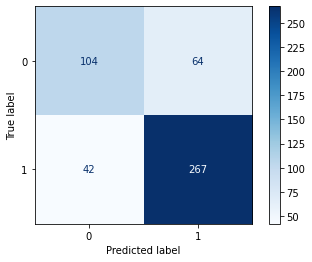

In [92]:
cm = confusion_matrix(y_test_2,y_pred)
print(cm)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(cm).plot(cmap='Blues')

In [93]:
print(f" The best score of Random forest is {round(rfc_grid.best_score_*100,0)}")

 The best score of Random forest is 81.0


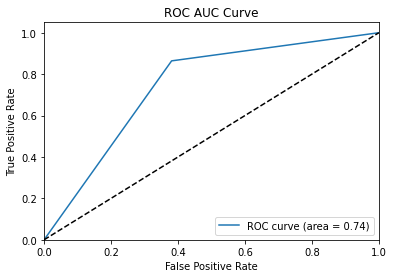

In [94]:
# ROC AUC curve for the above model
roc_score = roc_auc_score(y_test_2,y_pred)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()

In [95]:
### Random Forests feature importance
model = rfc_grid.best_estimator_
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

feature_importance = [x_test_2.columns[i] for i in indices]
feature_importance

['yeo_TBV',
 'rating_increased',
 'Quarterly Rating',
 'Grade',
 'boxcox_income',
 'zero_TBV',
 'Joining Designation',
 'City',
 'Age',
 'income_increased',
 'Education_Level',
 'negative_TBV',
 'Gender']

The top most important features in determining the churn rate of drivers according Random forests are:
* Total Business value
* Rating increased
* Quarterly rating 
* Grade

#### XGboost

In [96]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',random_state=0,class_weight='balanced')

In [97]:
params = {
    'n_estimators':[50,100,150,200],
    'max_depth':[1,2,3],
    'learning_rate':[0.001,0.01,0.05,0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

xgb_grid = GridSearchCV(estimator=xgb_model,param_grid=params,scoring='accuracy',
                       n_jobs=-1,verbose=1,return_train_score=True,cv=3)

In [98]:
xgb_grid.fit(x_train_2,y_train_2)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [00:42:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Param

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, class_weight='balanced',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1],
                         'max_depth': [1, 2, 3],
                         'n_estimators': [50, 100, 150, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [99]:
model2 = xgb_grid.best_estimator_

In [100]:
print(f" The best score of Xgboost is {round(xgb_grid.best_score_*100,0)}")

 The best score of Xgboost is 81.0


In [101]:
print(f" The best parameter in the above dictionary of params is {xgb_grid.best_params_}")

 The best parameter in the above dictionary of params is {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


In [102]:
y_pred_xgb = xgb_grid.predict(x_test_2)

              precision    recall  f1-score   support

           0       0.77      0.52      0.62       168
           1       0.78      0.92      0.84       309

    accuracy                           0.78       477
   macro avg       0.78      0.72      0.73       477
weighted avg       0.78      0.78      0.77       477



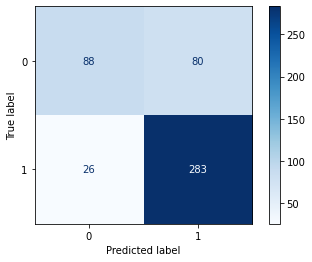

In [103]:
cm=confusion_matrix(y_test_2,y_pred_xgb)
print(classification_report(y_test_2,y_pred_xgb))
ConfusionMatrixDisplay(cm).plot(cmap='Blues')

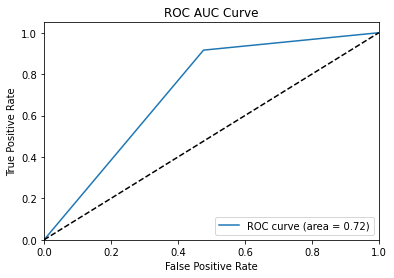

In [104]:
roc_score = roc_auc_score(y_test_2,y_pred_xgb)

fpr,tpr,thr = roc_curve(y_test_2,y_pred_xgb)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()

In [105]:
## Feature importances 
best_estimator = xgb_grid.best_estimator_
importances = best_estimator.feature_importances_
indices = np.argsort(importances)[::-1]
feature_importance = [x_test_2.columns[i] for i in indices]
feature_importance

['rating_increased',
 'yeo_TBV',
 'Quarterly Rating',
 'Joining Designation',
 'zero_TBV',
 'Grade',
 'City',
 'Age',
 'negative_TBV',
 'income_increased',
 'boxcox_income',
 'Gender',
 'Education_Level']

The top most important features in determining the churn rate of drivers according Random forests are:

* Rating increased
* Total Business Value
* Quarterly rating
* Joining Designation

### Gradient Boosting Classifier

In [106]:
gbc_model = gbc(random_state=0)

params = {
    'n_estimators':[50,100,150,200],
    'learning_rate':[0.01,0.05,0.1,0.15],
    'max_depth':[1,2,3],
    'ccp_alpha':[0.01,0.1,0.2],
    'max_features':[2,3,4]
}

In [107]:
gbc_grid = GridSearchCV(estimator=gbc_model,param_grid=params,scoring='accuracy',cv=3)

gbc_grid.fit(x_train_2,y_train_2)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'ccp_alpha': [0.01, 0.1, 0.2],
                         'learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'max_depth': [1, 2, 3], 'max_features': [2, 3, 4],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [108]:
print(f" Best parameters for gradient boosting classifier are {gbc_grid.best_params_}")
print(f" The best score is {round(gbc_grid.best_score_*100,0)}")

 Best parameters for gradient boosting classifier are {'ccp_alpha': 0.01, 'learning_rate': 0.15, 'max_depth': 3, 'max_features': 4, 'n_estimators': 50}
 The best score is 77.0


              precision    recall  f1-score   support

           0       0.79      0.48      0.60       168
           1       0.77      0.93      0.84       309

    accuracy                           0.77       477
   macro avg       0.78      0.71      0.72       477
weighted avg       0.78      0.77      0.76       477



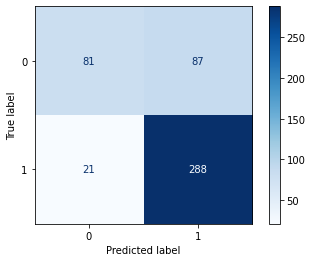

In [109]:
model3 = gbc_grid.best_estimator_ 
y_pred_gbc = gbc_grid.predict(x_test_2)
cm=confusion_matrix(y_test_2,y_pred_gbc)
print(classification_report(y_test_2,y_pred_gbc))
ConfusionMatrixDisplay(cm).plot(cmap='Blues')

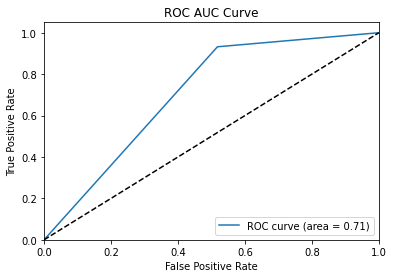

In [110]:
roc_score = roc_auc_score(y_test_2,y_pred_gbc)

fpr,tpr,thr = roc_curve(y_test_2,y_pred_gbc)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()

In [111]:
## Feature importances 
best_estimator = gbc_grid.best_estimator_
importances = best_estimator.feature_importances_
indices = np.argsort(importances)[::-1]
feature_importance = [x_test_2.columns[i] for i in indices]
feature_importance

['rating_increased',
 'yeo_TBV',
 'Quarterly Rating',
 'boxcox_income',
 'income_increased',
 'zero_TBV',
 'negative_TBV',
 'Grade',
 'Joining Designation',
 'Education_Level',
 'City',
 'Gender',
 'Age']

The top most important features in determining the churn rate of drivers according Random forests are:

* Rating increased
* Total Business Value
* Quarterly rating
* Income

### Churn Prediction Metrics:

* Precision: The precision measures the proportion of correctly predicted churn cases among all predicted churn cases.
* Recall: The recall measures the proportion of correctly predicted churn cases among all actual churn cases.
* F1 Score: The F1 score is the harmonic mean of precision and recall, providing a balance between the two metrics.
* ROC AUC: The ROC AUC (Area Under the Receiver Operating Characteristic Curve) measures the models' ability to distinguish between churn and non-churn instances.

### Insights and Recommendations
* XGboost and Random forests give higher accuracy compared to gadient boosted classifier.
* The recall for class 1 (i.e people who churn) for XGBoost and gradient boosting classfier is higher, that means these models predicts most of the people who are going to churn. 
* If we want higher recall OLA can use XGBoost or gradient boosting classifier.
* The most important features in determining the churn rate are total business value, quarterly rating, income. 
* None of the drivers in the given data set have recieved a Quarterly rating of 5.0.
* If OLA wants to decrease the churn they have to take steps to increase the business value and ratings for the drivers.